In [1]:
import os
import cv2
import h5py
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statistics import mean
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.utils.data.sampler import SubsetRandomSampler, BatchSampler, Sampler
from torch.optim import Adam, SGD
from torchvision import transforms, models
from torchvision.models import resnet18  
from torchvision.transforms import Resize, ToTensor
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from PIL import Image

torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
file_path_1 = '/kaggle/input/common-task1/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
file_path_2 = '/kaggle/input/common-task1/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
with h5py.File(file_path_1, 'r') as file:
    print(list(file.keys()))
    
with h5py.File(file_path_2, 'r') as file:
    print(list(file.keys()))

['X', 'y']
['X', 'y']


In [4]:
with h5py.File(file_path_1, 'r') as file:
    X1 = file['X'][:]
    y1 = file['y'][:]
    
with h5py.File(file_path_2, 'r') as file:
    X2 = file['X'][:]
    y2 = file['y'][:]

In [5]:
X = np.vstack([X1, X2])
y = np.concatenate([y1, y2])
print("Shape of merged_X:", X.shape)

Shape of merged_X: (498000, 32, 32, 2)


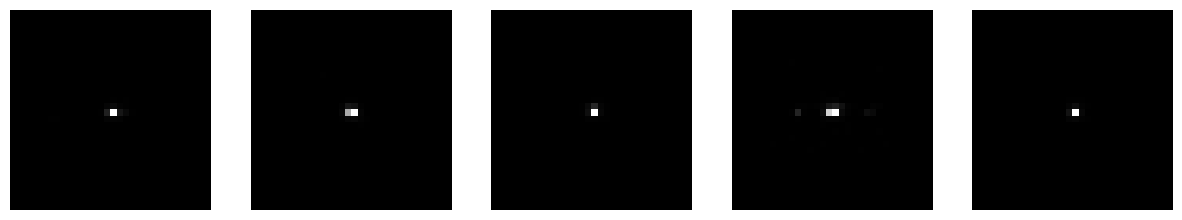

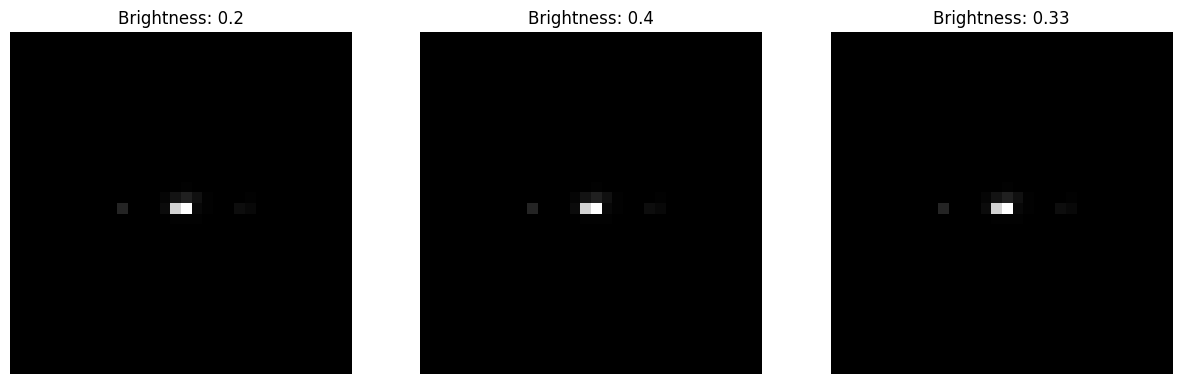

In [6]:
def brightness_adjustment_opencv(image, brightness_factor=0.5):
    image = (image * 255).astype(np.uint8)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    image_bgr = cv2.convertScaleAbs(image_bgr, beta=brightness_factor * 255)
    image_result = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    image_result = image_result.astype(np.float32) / 255.0

    return image_result


images_to_plot = X1[-5:]
fig, axes = plt.subplots(1, len(images_to_plot), figsize=(15, 5))
for i, image in enumerate(images_to_plot):
    axes[i].imshow(image[:, :, 0], cmap='gray')
    axes[i].axis('off')
plt.show()
brightness_factors = [0.2, 0.4, 0.33]  

fig, axes = plt.subplots(1, len(brightness_factors), figsize=(15, 5))
for j, brightness_factor in enumerate(brightness_factors):
    adjusted_image = brightness_adjustment_opencv(images_to_plot[3][:, :, 0], brightness_factor)
    axes[j].imshow(adjusted_image, cmap='gray') 
    axes[j].axis('off')
    axes[j].set_title(f'Brightness: {brightness_factor}')

plt.show()


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [8]:
X_train = (X_train - np.mean(X_train))/np.std(X_train)
print("Mean pixel value of training data:", np.mean(X_train))
print("Standard deviation of pixel values of training data:", np.std(X_train))

X_test = (X_test - np.mean(X_test))/np.std(X_test)
print("Mean pixel value of testing data:", np.mean(X_test))
print("Standard deviation of pixel values of testing data:", np.std(X_test))

Mean pixel value of training data: 1.9192365e-08
Standard deviation of pixel values of training data: 0.9999976
Mean pixel value of testing data: 6.372743e-09
Standard deviation of pixel values of testing data: 1.0000018


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify = y_train)

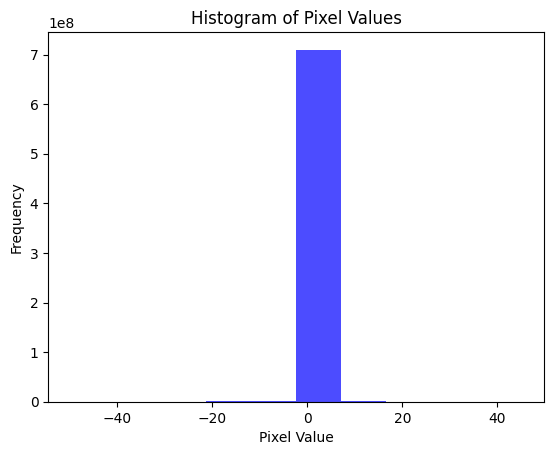

In [10]:
plt.hist(X_train.flatten(), color='blue', alpha=0.7)
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

In [11]:
class CFG:
    model_name = 'resnet15'
    input_size = (32, 32, 2)  
    batch_size = 32
    learning_rate = 1e-3
    num_epochs = 15
    warmup_steps = 10
    cooldown_steps = 10

In [12]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet15(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(ResNet15, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return torch.sigmoid(out).squeeze()

In [13]:
class DatasetLoader:
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test, batch_size):
        self.batch_size = batch_size
        self.CFG = CFG
        self.train_loader = self.create_dataloader(X_train, y_train, shuffle=False)
        self.val_loader = self.create_dataloader(X_val, y_val, shuffle=True)
        self.test_loader = self.create_dataloader(X_test, y_test, shuffle=True)

    def create_dataloader(self, X, y, shuffle):
        X_tensor = torch.from_numpy(X).float()
        y_tensor = torch.from_numpy(y).float()
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=CFG.batch_size, shuffle=shuffle, drop_last=True)
    
dataset_loader = DatasetLoader(X_train, y_train, X_val, y_val, X_test, y_test, CFG.batch_size)

In [28]:
model = ResNet15(BasicBlock, [2, 2, 2]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG.num_epochs // 2, T_mult=2, eta_min=1e-6, last_epoch=-1, verbose=True)

Epoch 00000: adjusting learning rate of group 0 to 1.0000e-03.


In [29]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
roc_auc_scores_train = []  
roc_auc_scores_val = []    
epoch_count = []

best_roc_auc = 0.0
best_model_state_dict = None

for epoch in range(CFG.num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    y_true = []
    y_scores = []

    with tqdm(dataset_loader.train_loader, desc=f"Epoch {epoch+1}/{CFG.num_epochs}", leave=False) as train_loader_with_progress:
        for i, data in enumerate(train_loader_with_progress, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.permute(0, 3, 1, 2))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs.cpu().detach().numpy())

    train_loss.append(running_loss / len(dataset_loader.train_loader))
    train_accuracy = correct_predictions / total_predictions
    train_acc.append(train_accuracy)
    epoch_count.append(epoch + 1)
    roc_auc_train = roc_auc_score(y_true, y_scores)
    roc_auc_scores_train.append(roc_auc_train)

    model.eval()
    val_running_loss = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    correct_predictions_count = 0
    y_true_val = []
    y_scores_val = []

    with torch.no_grad():
        for inputs_val, labels_val in dataset_loader.val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            outputs_val = model(inputs_val.permute(0, 3, 1, 2))
            val_loss_batch = criterion(outputs_val, labels_val)
            val_running_loss += val_loss_batch.item()
            predicted_val = (outputs_val > 0.5).float()
            correct_predictions_val += (predicted_val == labels_val).sum().item()
            total_predictions_val += labels_val.size(0)
            y_true_val.extend(labels_val.cpu().numpy())
            y_scores_val.extend(outputs_val.cpu().detach().numpy())

    val_loss.append(val_running_loss / len(dataset_loader.val_loader))
    val_accuracy = correct_predictions_val / total_predictions_val
    val_acc.append(val_accuracy)
    roc_auc_val = roc_auc_score(y_true_val, y_scores_val)
    roc_auc_scores_val.append(roc_auc_val)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Train ROC-AUC: {roc_auc_train:.3f}, Val ROC-AUC: {roc_auc_val:.3f}")

    scheduler.step()

    if roc_auc_val > best_roc_auc:
        best_roc_auc = roc_auc_val
        best_model_state_dict = model.state_dict()

torch.save(best_model_state_dict, "model_weights_Common_Task_1.pth")
print("Model saved successfully.")
print("Finished training")

Epoch 1, Train Loss: 0.6138, Val Loss: 0.2858, Train Acc: 0.6663, Val Acc: 0.7123, Train ROC-AUC: 0.721, Val ROC-AUC: 0.773
Epoch 00001: adjusting learning rate of group 0 to 9.5053e-04.


Epoch 2, Train Loss: 0.5766, Val Loss: 0.2819, Train Acc: 0.7076, Val Acc: 0.7198, Train ROC-AUC: 0.767, Val ROC-AUC: 0.785
Epoch 00002: adjusting learning rate of group 0 to 8.1193e-04.


Epoch 3, Train Loss: 0.5603, Val Loss: 0.2775, Train Acc: 0.7207, Val Acc: 0.7251, Train ROC-AUC: 0.784, Val ROC-AUC: 0.792
Epoch 00003: adjusting learning rate of group 0 to 6.1165e-04.


Epoch 4, Train Loss: 0.5509, Val Loss: 0.2750, Train Acc: 0.7270, Val Acc: 0.7263, Train ROC-AUC: 0.793, Val ROC-AUC: 0.796
Epoch 00004: adjusting learning rate of group 0 to 3.8935e-04.


Epoch 5, Train Loss: 0.5431, Val Loss: 0.2721, Train Acc: 0.7323, Val Acc: 0.7308, Train ROC-AUC: 0.800, Val ROC-AUC: 0.800
Epoch 00005: adjusting learning rate of group 0 to 1.8907e-04.


Epoch 6, Train Loss: 0.5363, Val Loss: 0.2694, Train Acc: 0.7366, Val Acc: 0.7340, Train ROC-AUC: 0.806, Val ROC-AUC: 0.805
Epoch 00006: adjusting learning rate of group 0 to 5.0466e-05.


Epoch 7, Train Loss: 0.5315, Val Loss: 0.2678, Train Acc: 0.7396, Val Acc: 0.7356, Train ROC-AUC: 0.810, Val ROC-AUC: 0.807
Epoch 00007: adjusting learning rate of group 0 to 1.0000e-03.


Epoch 8, Train Loss: 0.5516, Val Loss: 0.2736, Train Acc: 0.7262, Val Acc: 0.7281, Train ROC-AUC: 0.792, Val ROC-AUC: 0.798
Epoch 00008: adjusting learning rate of group 0 to 9.8748e-04.


Epoch 9, Train Loss: 0.5491, Val Loss: 0.2732, Train Acc: 0.7279, Val Acc: 0.7298, Train ROC-AUC: 0.794, Val ROC-AUC: 0.800
Epoch 00009: adjusting learning rate of group 0 to 9.5053e-04.


Epoch 10, Train Loss: 0.5455, Val Loss: 0.2724, Train Acc: 0.7304, Val Acc: 0.7291, Train ROC-AUC: 0.798, Val ROC-AUC: 0.801
Epoch 00010: adjusting learning rate of group 0 to 8.9102e-04.


Epoch 11, Train Loss: 0.5415, Val Loss: 0.2721, Train Acc: 0.7332, Val Acc: 0.7295, Train ROC-AUC: 0.801, Val ROC-AUC: 0.802
Epoch 00011: adjusting learning rate of group 0 to 8.1193e-04.


Epoch 12, Train Loss: 0.5377, Val Loss: 0.2712, Train Acc: 0.7354, Val Acc: 0.7316, Train ROC-AUC: 0.805, Val ROC-AUC: 0.803
Epoch 00012: adjusting learning rate of group 0 to 7.1722e-04.


Epoch 13, Train Loss: 0.5340, Val Loss: 0.2699, Train Acc: 0.7381, Val Acc: 0.7326, Train ROC-AUC: 0.808, Val ROC-AUC: 0.804
Epoch 00013: adjusting learning rate of group 0 to 6.1165e-04.


Epoch 14, Train Loss: 0.5295, Val Loss: 0.2695, Train Acc: 0.7411, Val Acc: 0.7332, Train ROC-AUC: 0.812, Val ROC-AUC: 0.804
Epoch 00014: adjusting learning rate of group 0 to 5.0050e-04.


Epoch 15, Train Loss: 0.5249, Val Loss: 0.2695, Train Acc: 0.7440, Val Acc: 0.7339, Train ROC-AUC: 0.816, Val ROC-AUC: 0.805
Epoch 00015: adjusting learning rate of group 0 to 3.8935e-04.
Model saved successfully.
Finished training


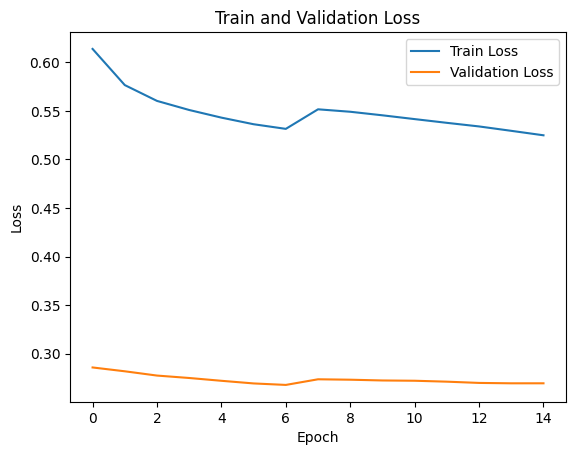

In [30]:
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

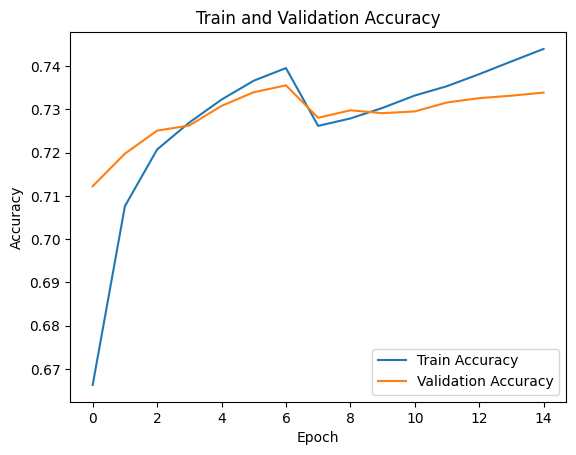

In [34]:
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

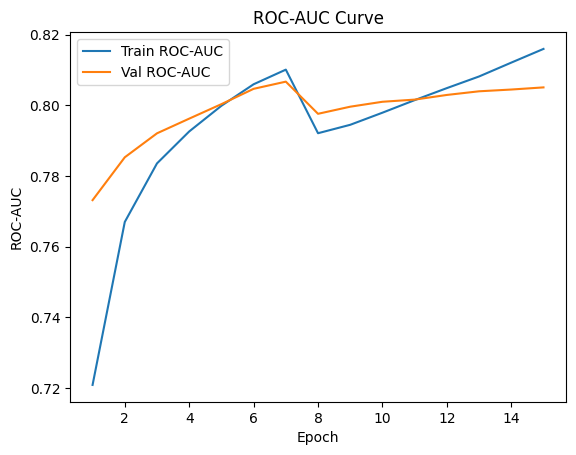

In [32]:
plt.plot(epoch_count, roc_auc_scores_train, label='Train ROC-AUC')
plt.plot(epoch_count, roc_auc_scores_val, label='Val ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()


In [33]:
checkpoint = torch.load("/kaggle/working/model_weights_Common_Task_1.pth")
model = ResNet15(BasicBlock, [2, 2, 2]).to(device)
model.load_state_dict(checkpoint)
model.eval()  
test_running_loss = 0.0
correct_predictions_test = 0
total_predictions_test = 0
y_true_test = []
y_scores_test = []

with torch.no_grad():
    for inputs_test, labels_test in test_loader:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs_test = model(inputs_test.permute(0, 3, 1, 2))
        test_loss_batch = criterion(outputs_test, labels_test)
        test_running_loss += test_loss_batch.item()
        predicted_test = (outputs_test > 0.5).float()
        correct_predictions_test += (predicted_test == labels_test).sum().item()
        total_predictions_test += labels_test.size(0)
        y_true_test.extend(labels_test.cpu().numpy())
        y_scores_test.extend(outputs_test.cpu().detach().numpy())

test_loss = test_running_loss / len(test_loader)
test_accuracy = correct_predictions_test / total_predictions_test
roc_auc_test = roc_auc_score(y_true_test, y_scores_test)
accuracy_test = accuracy_score(y_true_test, (np.array(y_scores_test) > 0.5))

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test ROC-AUC: {roc_auc_test:.4f}")


Test Loss: 0.5398, Test Accuracy: 0.7346, Test ROC-AUC: 0.8044
